In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
%matplotlib inline

In [54]:
df = pd.read_csv("A2_data.csv")

In [39]:
# find where the g is negative
print( df[df['g'] < 0] )
print( df[df['u'] < 0] )
print( df[df['z'] < 0] )

            alpha     delta       u       g        r         i       z  \
79543  224.006526 -0.624304 -9999.0 -9999.0  18.1656  18.01675 -9999.0   

       field_ID    MJD  redshift  plate class  
79543       537  58146     1.828   7834  STAR  
            alpha     delta       u       g        r         i       z  \
79543  224.006526 -0.624304 -9999.0 -9999.0  18.1656  18.01675 -9999.0   

       field_ID    MJD  redshift  plate class  
79543       537  58146     1.828   7834  STAR  
            alpha     delta       u       g        r         i       z  \
79543  224.006526 -0.624304 -9999.0 -9999.0  18.1656  18.01675 -9999.0   

       field_ID    MJD  redshift  plate class  
79543       537  58146     1.828   7834  STAR  


In [55]:
# # drop row 79543
df= df.drop(79543, axis=0)

In [56]:
# unique classes
print(df['class'].unique())

labels = df['class']
# drop the class column
df = df.drop(['class','field_ID','plate'], axis=1)



['GALAXY' 'QSO' 'STAR']


In [42]:
df.head()

,alpha,delta,u,g,r,i,z,MJD,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,56064,-0.001584
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,53727,-0.824700
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,54883,-0.418000
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,51783,5.953000
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,56069,0.846000


UMAP

In [57]:
scaler = StandardScaler()
umap = umap.UMAP(n_components=2)
scaled = scaler.fit_transform(df)
transformed = umap.fit_transform(scaled)

In [58]:
transformed_UMAP = pd.DataFrame(transformed, columns=['UMAP1', 'UMAP2'])
key=transformed_UMAP.keys()
transformed_UMAP

,UMAP1,UMAP2
0,11.842771,12.535317
1,7.833437,15.047935
2,11.550183,11.616508
3,-2.988385,3.508646
4,-2.117115,7.111017
...,...,...
99994,11.151685,-3.976663
99995,11.040890,-2.212005
99996,7.201070,8.499929
99997,11.384336,10.085896


Random Forest Classifier

In [59]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(transformed_UMAP, labels, test_size=0.3, random_state=123, stratify=labels)
clf = RandomForestClassifier()

In [14]:
#scale the data to speed up Random Forest
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train_scaled = scaling.transform(x_train)
x_test_scaled = scaling.transform(x_test)

Hyperparameter Optimisation

In [20]:
#Parameters of RandomForest
pprint(clf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [15]:
#tuning using Random Search
hyperparameters = {'max_features':[None, 'auto', 'sqrt', 'log2'],
                   'max_depth':[None, 1, 5, 10, 15, 20],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                   'criterion': ['gini', 'entropy']}
rf_random = RandomizedSearchCV(clf, hyperparameters, n_iter = 50, cv = 5, verbose=2, random_state=123, n_jobs = -1)
rf_random.fit(x_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    max_features=None,
                                                    n_estimators=80),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 1, 5, 10, 15, 20],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=123, verbose=2)

In [16]:
rf_random.best_params_

{'n_estimators': 70,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 10,
 'criterion': 'entropy'}

Cross Validation Score

In [17]:
# from sklearn.model_selection import cross_val_score

# cross_score = cross_val_score(clf,features,labels,cv = 5,scoring = "accuracy")
# print(f' Scores for each fold are: {cross_score}')
# print(f' Average score: {"{:.2f}".format(cross_score.mean())}')

Training the RandomForest

In [60]:
clf.set_params(criterion = 'entropy', max_features = None, max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 80)

RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=80)

Test and Evaluation

In [61]:
from sklearn.metrics import accuracy_score, f1_score

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

In [62]:
print('features importances are : ' , clf.feature_importances_)

features importances are :  [0.50477896 0.49522104]


<BarContainer object of 2 artists>

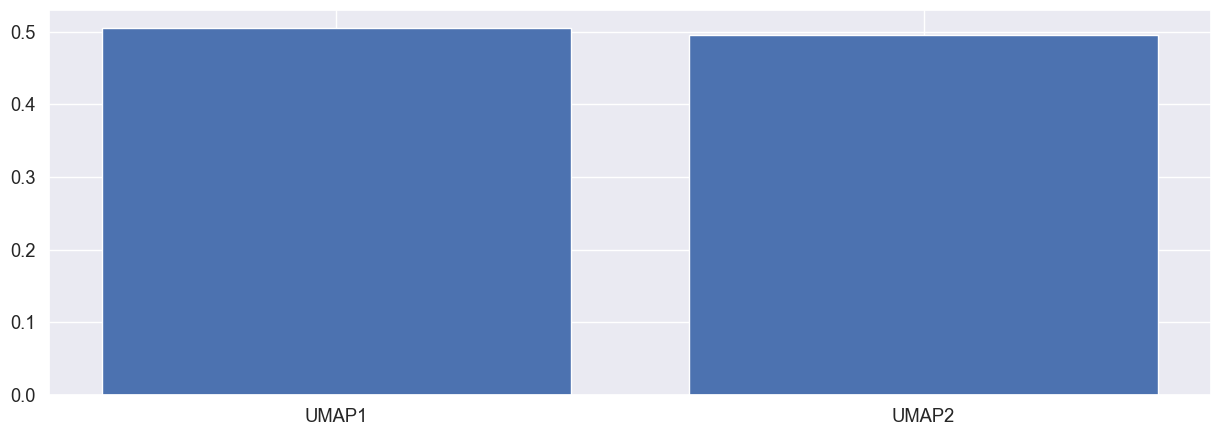

In [63]:
#Visualize feature importance

plt.figure(figsize=(15,5))
plt.bar(key,clf.feature_importances_)

In [64]:
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

Classification report and confusion matrix

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

              precision    recall  f1-score   support

      GALAXY       0.78      0.87      0.82     17834
         QSO       0.61      0.63      0.62      5688
        STAR       0.43      0.28      0.34      6478

    accuracy                           0.70     30000
   macro avg       0.61      0.59      0.59     30000
weighted avg       0.67      0.70      0.68     30000

[[15440   890  1504]
 [ 1130  3579   979]
 [ 3254  1387  1837]]


Visualization of Confusion Matrix

Text(43.25, 0.5, 'True')

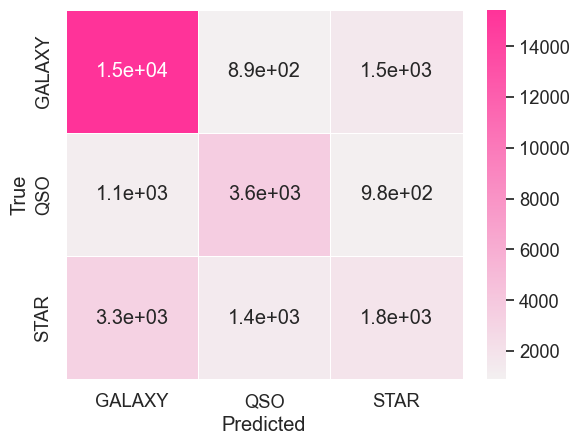

In [66]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')